# Project 2: Continuous Control Multimodel

This notebook demonstrates how an agent can be trained for multiple models.

All parameters are defined in the `Config` class of the `utils` module and preset to default values at instantiation. This includes all paths, hyperparameters and even the environment. 

Imported from the same module is the `MyEncoder` method to allow custom serialization

The `training` module defines the `ddpg` method implementing the DDPG algorithm used in this project to train the agent who is defined in module `ddpg_agent`.

In [1]:
from training import ddpg
from utils import Config, MyEncoder

from ddpg_agent import Agent

In [2]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import json
import numpy as np
import pandas as pd

from itertools import product
from operator import add, sub
from time import sleep

/home/robond/anaconda3/envs/drlnd/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  


## Helpers

The following function is used to generate the models from several parameters using the itertools product function to generate all possible permutations.

In [3]:
def product_dict(**kwargs):
    keys = kwargs.keys()
    vals = kwargs.values()

    for instance in product(*vals):
        yield dict(zip(keys, instance))

## Models

Create all possible permutations of fc1_units, fc2_units and gamma for the given values. The number of models is:
$$n_{total} = n_1 \cdot n_2 \cdot n_\gamma$$
With $n_1, n_2 \in \{128, 256, 512\}$ and $\gamma \in \{0.90 \ldots 0.99\}$:
$$n_{total} = 3 \cdot 3 \cdot 10 = 90$$

In [4]:
model_grid = {'fc1_units': [128, 256, 512], 'fc2_units': [128, 256, 512], 
              'gamma': [.90, .91, .92, .93, .94, .95, .96, .97, .98, .99]}

In [5]:
models = list()

for i, model in enumerate(list(product_dict(**model_grid))):
    models.append(model)

print(f'{len(models)} models generated')

models[:10]

90 models generated


[{'fc1_units': 128, 'fc2_units': 128, 'gamma': 0.9},
 {'fc1_units': 128, 'fc2_units': 128, 'gamma': 0.91},
 {'fc1_units': 128, 'fc2_units': 128, 'gamma': 0.92},
 {'fc1_units': 128, 'fc2_units': 128, 'gamma': 0.93},
 {'fc1_units': 128, 'fc2_units': 128, 'gamma': 0.94},
 {'fc1_units': 128, 'fc2_units': 128, 'gamma': 0.95},
 {'fc1_units': 128, 'fc2_units': 128, 'gamma': 0.96},
 {'fc1_units': 128, 'fc2_units': 128, 'gamma': 0.97},
 {'fc1_units': 128, 'fc2_units': 128, 'gamma': 0.98},
 {'fc1_units': 128, 'fc2_units': 128, 'gamma': 0.99}]

## Training

Let's now train 20 agents connected to a single brain for all the generated models. Because of a broken pipe error, each model has to be trained manually setting `m` to a value between 1 and 90, then restarting the kernel.

A new model directory will be created by auto-incrementing the number in the path, dumping the configuration file

In [6]:
m = 89
models[m]

{'fc1_units': 512, 'fc2_units': 512, 'gamma': 0.99}

Path results already exists


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


{'device': device(type='cpu'), 'n_agents': 20, 'model_id_auto': True, 'model_id': 106, 'env_path': PosixPath('A20/Reacher.x86_64'), 'brain_name': 'ReacherBrain', 'state_dim': 33, 'action_dim': 4, 'n_episodes': 400, 'max_t': 1000, 'buffer_size': 100000, 'batch_size': 64, 'gamma': 0.99, 'tau': 0.001, 'lr_actor': 0.001, 'lr_critic': 0.0001, 'critic_weight_decay': 0, 'fc1_units': 512, 'fc2_units': 512, 'seed': 48, 'n_print': 20, 'target': 30, 'window': 100, 'target_episode': None, 'target_score': None}
Episode   20	Current Score  6.43	Avg Score  2.66	Std Score  2.11
Episode   40	Current Score 38.50	Avg Score 16.49	Std Score 15.80
Episode   60	Current Score 38.03	Avg Score 23.76	Std Score 16.50
Episode   80	Current Score 38.09	Avg Score 27.31	Std Score 15.55
Episode  100	Current Score 38.14	Avg Score 29.42	Std Score 14.54
Episode  102	Current Score 37.90	Avg Score 30.16	Std Score 13.99
Environment solved in 2 episodes	Average Score: 30.16


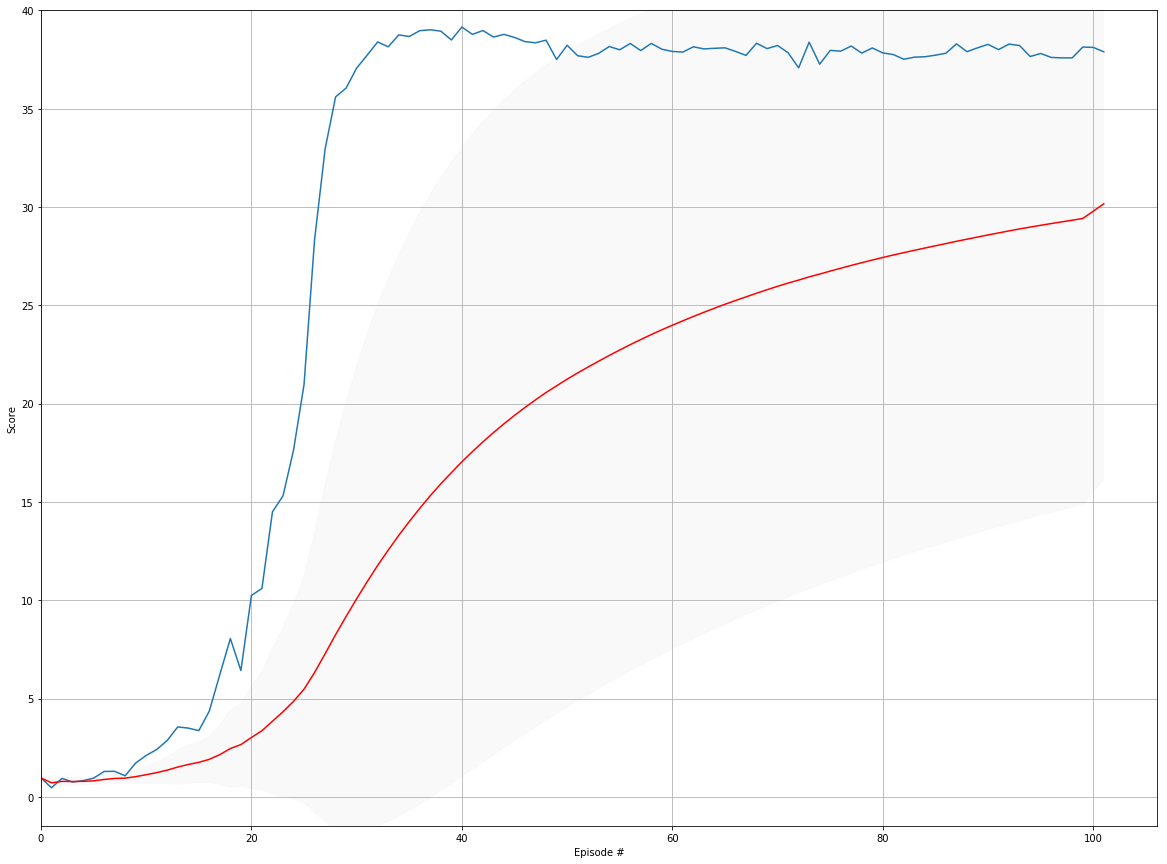

In [7]:
for model in models[m:]:
    
    config = Config(n_agents=20)
    config.fc1_units = model['fc1_units']
    config.fc2_units = model['fc2_units']
    config.gamma = model['gamma']

    print(config.to_dict())
    
    agent = Agent(config)
    
    scores, ma_scores, std_scores = ddpg(agent, config)
    
    with open(f'{config.model_dir}/config.json', 'w') as f:
        json.dump(config.to_dict(), f, cls=MyEncoder)

    fig = plt.figure(figsize=(20, 15))

    x = np.arange(len(scores))

    plt.plot(x, scores)
    plt.plot(x, ma_scores, color='r')
    plt.ylabel('Score')
    bottom, top = plt.ylim()
    plt.ylim(bottom, 40)

    plt.xlabel('Episode #')
    left, right = plt.xlim()
    plt.xlim(0, right)

    plt.grid(True)

    font = {'size': 12}
    plt.rc('font', **font)

    plt.fill_between(x, list(map(sub, ma_scores, std_scores)), list(map(add, ma_scores, std_scores)), 
                     color='whitesmoke', alpha=.5)

    plt.savefig(f'results/model {config.model_id}/scores.png')
    # plt.show()

    df = pd.DataFrame({'episode': np.arange(len(scores)), 'score': scores, 'ma': ma_scores, 'std': std_scores})
    df.set_index('episode', inplace=True)
    df.to_csv(f'results/model {config.model_id}/scores.csv')
    
    config.env.close()
    
    del config
    
    break